In [1]:
from sqlalchemy import create_engine

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV

from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

In [2]:
localhost = {'user': 'postgres', 'password': 'postgres', 'host': 'localhost', 'port': 5432, 'db': 'fiadb'}
params = 'postgresql://{0}:{1}@{2}:{3}/{4}'
engine = create_engine(params.format(localhost['user'], localhost['password'], localhost['host'], localhost['port'], localhost['db']))
# geom_sql = """select distinct grid_id, grid_geom from fs_fiadb.pergrid"""
pergrid_base = """select distinct * from predictor.pergrid_base"""
pergrid_base_df = pd.read_sql(pergrid_base, engine)
print(pergrid_base_df.shape)
pergrid_base_df_na_remove = pergrid_base_df.dropna()
print(pergrid_base_df_na_remove.shape)

(15310, 22)
(13503, 22)


In [3]:
pergrid_base_df_na_remove.columns

Index(['grid_id', 'aet', 'ai', 'art', 'ewd', 'fa', 'map', 'mat', 'mpdq',
       'mtcq', 'pet', 'psn', 'ra', 'rmap', 'rmat', 'tsn', 'mfdf', 'alt',
       'hydrogroup', 'mtwq', 'wkb_geometry', 'tsr'],
      dtype='object')

In [4]:
pergrid_base_encoded=pd.get_dummies(pergrid_base_df_na_remove, columns=["hydrogroup"])
# from sklearn.preprocessing import LabelEncoder
# number = LabelEncoder()
# pergrid_base_df_na_remove.loc[: ,'hydrogroup'] = number.fit_transform(pergrid_base_df_na_remove['hydrogroup'])
# pergrid_base_encoded = pergrid_base_df_na_remove

In [5]:
pergrid_base_encoded.columns

Index(['grid_id', 'aet', 'ai', 'art', 'ewd', 'fa', 'map', 'mat', 'mpdq',
       'mtcq', 'pet', 'psn', 'ra', 'rmap', 'rmat', 'tsn', 'mfdf', 'alt',
       'mtwq', 'wkb_geometry', 'tsr', 'hydrogroup_A', 'hydrogroup_A/D',
       'hydrogroup_B', 'hydrogroup_B/D', 'hydrogroup_C', 'hydrogroup_C/D',
       'hydrogroup_D'],
      dtype='object')

In [6]:
pred_var= ['aet', 'ai', 'art', 'ewd', 'fa', 'map', 'mat', 'mpdq',
       'mtcq', 'pet', 'psn', 'ra', 'rmap', 'rmat', 'tsn', 'mfdf', 'alt',
       'mtwq', 'hydrogroup_A', 'hydrogroup_A/D',
       'hydrogroup_B', 'hydrogroup_B/D', 'hydrogroup_C', 'hydrogroup_C/D',
       'hydrogroup_D']

X = pergrid_base_encoded[pred_var]

# standarize predictors
ss = StandardScaler(with_mean=False, with_std=False)
X_std = ss.fit_transform(X.values)

Xstd=pd.DataFrame(data=X_std[0:,0:],
                index=X.index,
                columns=pred_var)

In [7]:
y_true = pergrid_base_encoded['tsr']

In [8]:
X_train, X_test, y_train, y_test = train_test_split(Xstd, y_true, test_size=0.3, shuffle=True)

In [9]:
"""Lasso modeling with alpha=0.000001"""
lasso00001 = Lasso(alpha=0.0001, max_iter=10e5)
lasso00001.fit(Xstd, y_true)

test_score=lasso00001.score(X_test,y_test)
print("Test score for alpha =0.0001: ", test_score)

Test score for alpha =0.0001:  0.8015713458262681


In [10]:
"""Lasso Cross-validation modeling with eps=0.000001"""
lassocv = LassoCV(eps=0.000001, max_iter=10e6, n_alphas=1000, cv=10, random_state=None)
lassocv.fit(Xstd, y_true)

LassoCV(alphas=None, copy_X=True, cv=10, eps=1e-06, fit_intercept=True,
        max_iter=10000000.0, n_alphas=1000, n_jobs=None, normalize=False,
        positive=False, precompute='auto', random_state=None,
        selection='cyclic', tol=0.0001, verbose=False)

In [15]:
test_score_cv=lassocv.score(X_test,y_test)
print("Test score for 10-fold Cross-validation Lasso: ", test_score_cv)

Test score for 10-fold Cross-validation Lasso:  0.7837440880574493


In [35]:
df = pd.DataFrame(list(zip(pred_var, lassocv.coef_.tolist())), columns =['Features', 'Lasso_Coefficents'])
df.loc[df['Lasso_Coefficents']==0]

,Features,Lasso_Coefficents
1,ai,-0.0
2,art,0.0
6,mat,0.0
8,mtcq,0.0
10,psn,0.0
12,rmap,-0.0
13,rmat,0.0
15,mfdf,-0.0
17,mtwq,0.0
18,hydrogroup_A,0.0


In [36]:
df

,Features,Lasso_Coefficents
0,aet,-0.000008
1,ai,-0.000000
2,art,0.000000
3,ewd,0.000007
4,fa,0.059002
5,map,-0.000141
6,mat,0.000000
7,mpdq,0.071323
8,mtcq,0.000000
9,pet,0.017740


In [33]:
df_lasso = df.loc[df['Lasso_Coefficents']!=0]
df_lasso_sort = df_lasso.iloc[df_lasso['Lasso_Coefficents'].abs().argsort()]

In [34]:
df_lasso_sort

,Features,Lasso_Coefficents
3,ewd,0.000007
0,aet,-0.000008
5,map,-0.000141
11,ra,-0.001147
16,alt,-0.004606
9,pet,0.017740
14,tsn,0.021595
4,fa,0.059002
7,mpdq,0.071323


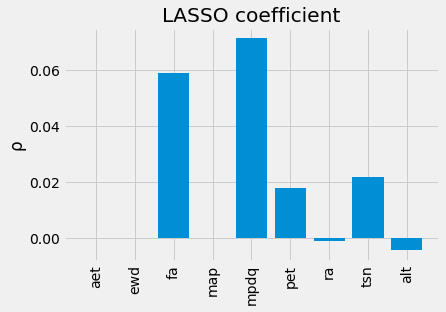

In [30]:
# Import matplotlib for plotting and use magic command for Jupyter Notebooks
import matplotlib.pyplot as plt
%matplotlib inline
# Set the style
plt.style.use('fivethirtyeight')
# list of x locations for plotting
x_values = list(range(df_lasso_sort.shape[0]))

# Make a bar chart
plt.bar(x_values, df_lasso['Lasso_Coefficents'], orientation = 'vertical')
# Tick labels for x axis
plt.xticks(x_values, df_lasso['Features'], rotation='vertical')
# Axis labels and title
plt.ylabel("ρ"); 
#plt.xlabel('Variable'); 
plt.title("LASSO coefficient");

In [29]:
df_lasso_sort

,Features,Lasso_Coefficents
3,ewd,0.000007
0,aet,-0.000008
5,map,-0.000141
11,ra,-0.001147
16,alt,-0.004606
9,pet,0.017740
14,tsn,0.021595
4,fa,0.059002
7,mpdq,0.071323


In [28]:
# Compute paths
model = LassoCV(eps=0.000001, max_iter=10e6, n_alphas=1000, cv=10, random_state=None).fit(Xstd, y_true)
EPSILON = 1e-4

# Display results
m_log_alphas = -np.log10(model.alphas_ + EPSILON)

(-6.918305077483188,
 -0.31831658192978524,
 17.810130694329093,
 291.00214371139646)

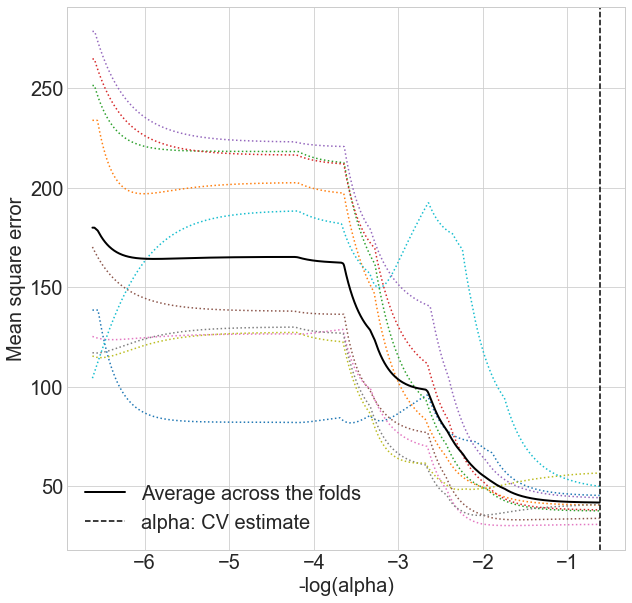

In [29]:
import matplotlib.pyplot as plt

plt.rcParams.update({'font.size': 20})
plt.style.use('seaborn-whitegrid')
fig = plt.figure(figsize=(10,10))
plt.tight_layout()

plt.plot(m_log_alphas, model.mse_path_, ':')
plt.plot(m_log_alphas, model.mse_path_.mean(axis=-1), 'k',
         label='Average across the folds', linewidth=2)
plt.axvline(-np.log10(model.alpha_ + EPSILON), linestyle='--', color='k',
            label='alpha: CV estimate')

plt.legend()
plt.xlabel('-log(alpha)')
plt.ylabel('Mean square error')
plt.axis('tight')

In [30]:
model.alpha_

4.152461364885147

In [31]:
model.mse_path_

array([[138.53552336, 233.90030953, 251.40611107, ..., 117.10566752,
        115.4725733 , 104.31473128],
       [138.53552336, 233.90030953, 251.40611107, ..., 117.06585254,
        115.36251334, 105.08345875],
       [138.53552336, 233.90030953, 251.40611107, ..., 117.03253667,
        115.26144841, 105.85229626],
       ...,
       [ 45.40149763,  40.59083506,  37.6301166 , ...,  40.78843182,
         56.64561248,  50.02340955],
       [ 45.39474671,  40.58843111,  37.62775849, ...,  40.79556892,
         56.65638186,  49.99000037],
       [ 45.3881049 ,  40.58606219,  37.62543733, ...,  40.80261357,
         56.66701044,  49.9570886 ]])

In [32]:
test_score_cv=model.score(X_test,y_test)
print("Test score for 10-fold Cross-validation Lasso: ", test_score_cv)

Test score for 10-fold Cross-validation Lasso:  0.7810359499288729
